<a href="https://colab.research.google.com/github/Monachaudhary/Awesome-hack-/blob/master/plant.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [2]:
%matplotlib inline

import os
import numpy as np
import matplotlib.pyplot as plt
from keras.preprocessing.image import ImageDataGenerator
from keras.models import Model
from keras.optimizers import Adam
from keras.utils import plot_model
from keras.applications.inception_v3 import InceptionV3
from keras.layers import Flatten, Dense, GlobalAveragePooling2D, Dropout
from keras.callbacks import ModelCheckpoint, LearningRateScheduler, EarlyStopping

In [4]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [34]:
!git clone https://github.com/Monachaudhary/Plant-Diseases-detection-web-app
%cd Plant-Diseases-detection-web-app

fatal: destination path 'Plant-Diseases-detection-web-app' already exists and is not an empty directory.
/content/Plant-Diseases-detection-web-app


In [35]:
BATCH_SIZE = 32
IMAGE_SIZE = 256
CHANNELS =3
EPOCHS =30
SHUFFLE_SIZE = 1000
IMG_SHAPE = (IMAGE_SIZE, IMAGE_SIZE, 3)

In [36]:
import tensorflow as tf
dataset = tf.keras.preprocessing.image_dataset_from_directory(
    '/content/drive/MyDrive/Leaves_Dataset',
    shuffle=True,
    image_size=(IMAGE_SIZE,IMAGE_SIZE),
    batch_size=BATCH_SIZE

)

Found 5175 files belonging to 19 classes.


In [11]:
class_names= dataset.class_names
class_names

['APPLE_ ROT_LEAVES',
 'APPLE_HEALTHY_LEAVES',
 'APPLE_LEAF_ BLOTCH',
 'APPLE_SCAB_LEAVES',
 'Pepper__bell___Bacterial_spot',
 'Pepper__bell___healthy',
 'Potato___Early_blight',
 'Potato___Late_blight',
 'Potato___healthy',
 'Tomato_Bacterial_spot',
 'Tomato_Early_blight',
 'Tomato_Late_blight',
 'Tomato_Leaf_Mold',
 'Tomato_Septoria_leaf_spot',
 'Tomato_Spider_mites_Two_spotted_spider_mite',
 'Tomato__Target_Spot',
 'Tomato__Tomato_YellowLeaf__Curl_Virus',
 'Tomato__Tomato_mosaic_virus',
 'Tomato_healthy']

In [12]:
for image_batch, labels_batch in dataset.take(1):
    print(image_batch.shape)
    print(labels_batch.numpy())

(32, 256, 256, 3)
[12  4  9 14 10  2 18 15 10 12 15  5 18  5  7 10 10 13 15  5  9  4 10 13
 18  5 18  4 13 16 11 10]


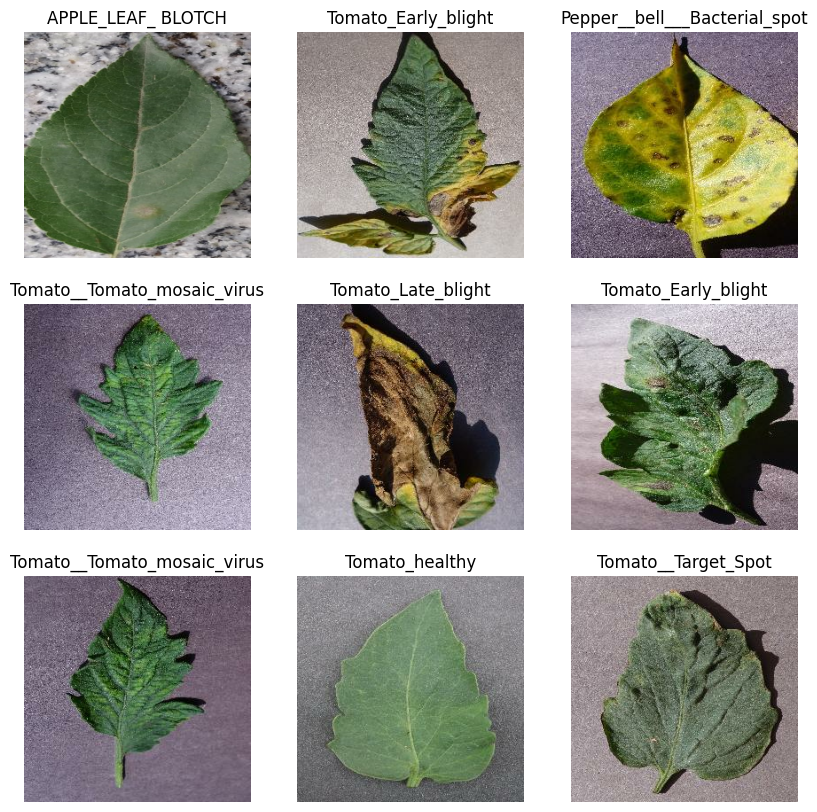

In [14]:
plt.figure(figsize=(10,10))
for image_batch, labels_batch in dataset.take(1):
     for i in range (9):
            ax = plt.subplot(3,3,i+1)
            plt.imshow(image_batch[i].numpy().astype("uint8"))
            plt.title(class_names[labels_batch[i]])
            plt.axis("off")

In [20]:
def get_dataset_partitions_tf(ds, train_split=0.8, val_split=0.1, test_split=0.1, shuffle=True, shuffle_size=10000):
    assert (train_split + test_split + val_split) == 1
    
    ds_size = len(ds)
    
    if shuffle:
        ds = ds.shuffle(shuffle_size, seed=12)
    
    train_size = int(train_split * ds_size)
    val_size = int(val_split * ds_size)
    
    train_ds = ds.take(train_size)    
    val_ds = ds.skip(train_size).take(val_size)
    test_ds = ds.skip(train_size).skip(val_size)
    
    return train_ds, val_ds, test_ds

In [21]:
train_ds, val_ds, test_ds = get_dataset_partitions_tf(dataset)


In [22]:
len(train_ds)

129

In [24]:
len(val_ds)

16

In [25]:
len(test_ds)

17

In [26]:
#In tensoflow every element is batch and the size of batch is 32
#total we have 32*54 image in training dataset
train_ds = train_ds.cache().shuffle(1000).prefetch(buffer_size=tf.data.AUTOTUNE)
val_ds = val_ds.cache().shuffle(1000).prefetch(buffer_size=tf.data.AUTOTUNE)
test_ds = test_ds.cache().shuffle(1000).prefetch(buffer_size=tf.data.AUTOTUNE)

In [28]:
# Building the Model of keras
# Creating a Layer for Resizing and Normalization
from tensorflow.keras import models, layers
resize_and_rescale = tf.keras.Sequential([
  layers.experimental.preprocessing.Resizing(IMAGE_SIZE, IMAGE_SIZE),
  layers.experimental.preprocessing.Rescaling(1./255),
])

In [29]:
#Data Augmentation
data_augmentation = tf.keras.Sequential([
  layers.experimental.preprocessing.RandomFlip("horizontal_and_vertical"),
  layers.experimental.preprocessing.RandomRotation(0.2),
])

In [30]:
#applying data augmentation to training dataset
train_ds = train_ds.map(
    lambda x, y: (data_augmentation(x, training=True), y)
).prefetch(buffer_size=tf.data.AUTOTUNE)

In [31]:
input_shape = (BATCH_SIZE, IMAGE_SIZE, IMAGE_SIZE, CHANNELS)
n_classes = 3

model = models.Sequential([
    resize_and_rescale,
    layers.Conv2D(32, kernel_size = (3,3), activation='relu', input_shape=input_shape),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(64,  kernel_size = (3,3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(64,  kernel_size = (3,3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(64, (3, 3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(64, (3, 3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(64, (3, 3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Flatten(),
    layers.Dense(64, activation='relu'),
    layers.Dense(n_classes, activation='softmax'),
])

model.build(input_shape=input_shape)